### Huấn luyện và dự đoán

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from helper.text_helper import find_words

#### Trực quan hóa dữ liệu đầu vào

In [22]:
df = pd.read_csv('data/csv/Danh_gia_final.csv', usecols=['ma_khach_hang', 'ma_san_pham', 'noi_dung_binh_luan', 'noi_dung_binh_luan_sau_xu_ly', 'so_sao'])
df.head()

,ma_khach_hang,noi_dung_binh_luan,so_sao,ma_san_pham,noi_dung_binh_luan_sau_xu_ly
0,443,SỬ DỤNG DỄ DÀNG RẤT THOẢI MÁI THƯ GIÃN TỘT ĐỘ,5,308500015,dễ_dàng thoải_mái thư_giãn
1,1030,Sử dụng dễ dãng rất thoải mái thư giãn tột độ,5,308500015,dãng thoải_mái thư_giãn
2,689,Mình rất thích hasaki va sp tẩy trang này,5,422216594,thích tẩy_trang
3,2519,Sản phẩm có khả năng làm sạch tốt Lớp trang đi...,5,204100075,khả_năng sạch tốt lớp trang_điểm mắt môi_chóng...
4,402,Sữa rửa mặt tốt sạch mụn mịn da đáng mua nha,5,422208977,sữa rửa mặt tốt sạch mụn mịn


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22720 entries, 0 to 22719
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   ma_khach_hang                 22720 non-null  object
 1   noi_dung_binh_luan            22690 non-null  object
 2   so_sao                        22720 non-null  int64 
 3   ma_san_pham                   22720 non-null  int64 
 4   noi_dung_binh_luan_sau_xu_ly  21701 non-null  object
dtypes: int64(2), object(3)
memory usage: 887.6+ KB


In [24]:
df['noi_dung_binh_luan'] = df['noi_dung_binh_luan'].astype(str)
df['noi_dung_binh_luan_sau_xu_ly'] = df['noi_dung_binh_luan_sau_xu_ly'].astype(str)

In [25]:
# Gán nhãn sentiment dựa trên số sao
df["sentiment"] = df["so_sao"].apply(lambda x: "positive" if x >= 4 else "negative" if x <= 2 else "neutral")

In [27]:
df.tail()

,ma_khach_hang,noi_dung_binh_luan,so_sao,ma_san_pham,noi_dung_binh_luan_sau_xu_ly,sentiment
22715,customer_code 9516,Chỉ thoảng mùi cà phê hạt scrub khá to và dín...,3,422205970,thoảng mùi cà_phê hạt scrub dính dần mịn không...,neutral
22716,customer_code 9517,hạt khá là to không như hãng khác,4,422205970,hạt không_như hãng,positive
22717,customer_code 9518,tẩy tbc hạt to lắm xoa tầm 67p là tan gần hết...,3,422205970,tẩy_tế báo chết hạt lắm tầm lớp sữa tắm_tẩy kh...,neutral
22718,customer_code 9519,Hạt đường to làm rát da sau khi tắm da cũng c...,1,422205970,hạt đường rát_tắm ẩm bình tầm giá xài cocon ổn,negative
22719,customer_code 9520,mới mua tặng vợ vợ xài kêu thích lắm nên chắc...,5,422205970,tặng vợ vợ xài kêu thích lắm,positive


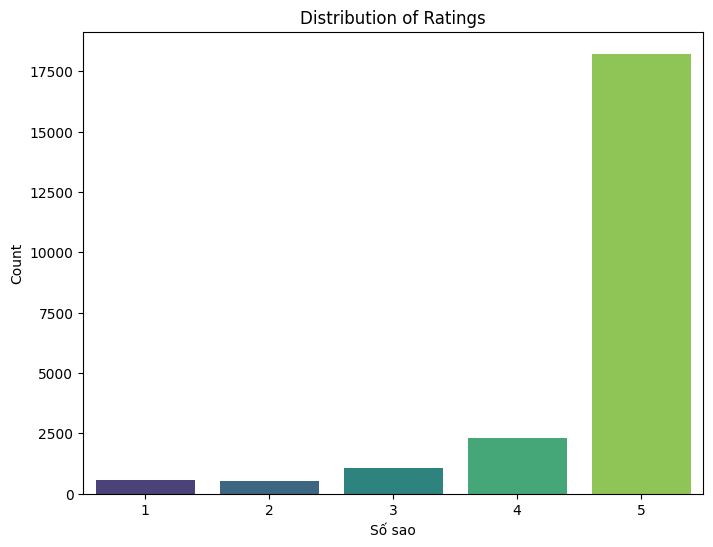

In [7]:
# Trực quan hóa phân phối số sao
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='so_sao', palette='viridis')
plt.title("Distribution of Ratings")
plt.xlabel("Số sao")
plt.ylabel("Count")
plt.show()

In [8]:
# Đếm số lượng sentiment
sentiment_counts = df["sentiment"].value_counts()
sentiment_counts

sentiment
positive    20555
neutral      1085
negative     1080
Name: count, dtype: int64

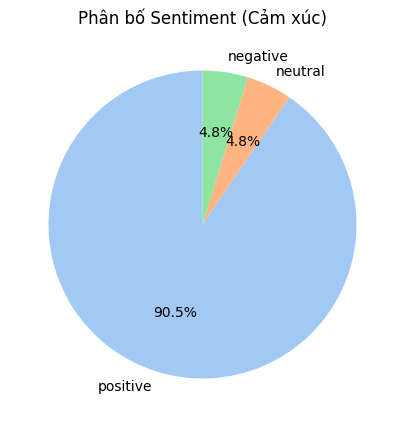

In [9]:
# Trực quan hóa Sentiment
plt.figure(figsize=(8, 5))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("pastel"),
)
plt.title("Phân bố Sentiment (Cảm xúc)")
plt.show()

#### Feature Engineering

In [10]:
positive_words = [
    "ok", "thoải mái", "hiệu quả", "nâng tông", "mướt", "mịn", "dễ chịu", "mượt", "thơm", "dịu nhẹ", "tươi trẻ", "mềm mại", "làm sáng", "làm đều màu",
    "chống lão hóa", "dưỡng ẩm", "ngừa mụn", "thư giãn", "không kích ứng", "tăng độ đàn hồi",
    "sạch sâu", "giảm thâm", "mát lạnh", "làm dịu", "tươi mát", "phục hồi", "dưỡng trắng",
    "trẻ hóa", "tẩy tế bào chết", "sáng da", "khôi phục", "bảo vệ", "chống nắng",

    "xem review", "ưu tiên thương hiệu", "chọn sản phẩm tự nhiên", "mua số lượng lớn", "canh giảm giá", "tìm khuyến mãi", "tin tưởng", "tặng quà", 
    "đăng ký thành viên", "quay lại mua", "đặt hàng online", "dùng voucher", 
    "chọn sản phẩm chính hãng",
    
    "thích", "tốt", "xuất sắc", "tuyệt vời", "ổn",
    "hài lòng", "ưng ý", "hoàn hảo", "chất lượng", "nhanh",
    "tiện lợi", "dễ sử dụng", "hiệu quả", "ấn tượng",
    "nổi bật", "thân thiện",
    "cao cấp", "độc đáo", "rất tốt", "rất thích", "tận tâm", "đáng tin cậy", "đẳng cấp",
    "hấp dẫn", "an tâm", "thúc đẩy", "cảm động", "phục vụ tốt", "làm hài lòng", "gây ấn tượng", "nổi trội",
    "sáng tạo", "phù hợp", "tận tâm", "hiếm có", "cải thiện", "hoà nhã", "chăm chỉ", "cẩn thận",
    "vui vẻ", "sáng sủa", "hào hứng", "đam mê", "vừa vặn", "đáng tiền"
]

In [11]:
negative_words = [
    "mắc", "khô", "nặng", "dầu", "kích ứng", "dị ứng", "tắc nghẽn lỗ chân lông", 
    "ngứa", "bóng nhờn", "tạo cảm giác dính", "khó thấm", "bít tắc", 
    "nặng mặt", "kém hiệu quả", "bóng dầu", "thô ráp", "lão hóa", "đỏ rát",
    "mùi hôi", "không hiệu quả",

    "chọn sản phẩm kém chất lượng", "chọn sản phẩm không phù hợp",

    "kém", "tệ", "buồn", "chán", "không dễ chịu", "không chất lượng"
    "kém chất lượng", "không thích", "không ổn",
    "không hợp", "không đáng tin cậy", "không chuyên nghiệp",
    "không phản hồi", "không an toàn", "không phù hợp", "không thân thiện", "không linh hoạt", "không đáng giá",
    "không ấn tượng", "không tốt", "chậm", "khó khăn", "phức tạp",
    "khó chịu", "gây khó dễ", "rườm rà", "thất bại", "tồi tệ", "khó xử", "không thể chấp nhận", "tồi tệ","không rõ ràng",
    "không chắc chắn", "rối rắm", "không tiện lợi", "không đáng tiền",
    'không hài lòng', 'không đáng', 'quá tệ', 'rất tệ',
    'thất vọng', 'chán', 'tệ hại', 'kinh khủng', 'không ưng ý'
]

In [12]:
positive_count, positive_word_list = find_words(df['noi_dung_binh_luan'][1000], positive_words)

print("Number of positive words:", positive_count)
print("List of positive words:", positive_word_list)

tuyệt vời
ổn
Number of positive words: 3
List of positive words: ['tuyệt vời', 'ổn']


In [13]:
X = df['noi_dung_binh_luan_sau_xu_ly']
y = df['sentiment']

#### Pipeline cho 4 thuật toán Machine Learning

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline  # Pipeline từ imbalanced-learn
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [15]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Tạo pipeline với SMOTE
pipeline = ImbPipeline([
    ("vectorizer", TfidfVectorizer(max_features=500)),  # Vector hóa dữ liệu văn bản
    ("smote", SMOTE(random_state=42)),                 # SMOTE để tăng mẫu cho lớp thiểu số
    ("classifier", RandomForestClassifier(random_state=42))  # Random Forest để phân loại
])

In [17]:
# Huấn luyện pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=500)),
                ('smote', SMOTE(random_state=42)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [18]:
# Đánh giá mô hình
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.61      0.84      0.71       226
     neutral       0.64      0.78      0.70       220
    positive       0.99      0.95      0.97      4098

    accuracy                           0.94      4544
   macro avg       0.75      0.86      0.79      4544
weighted avg       0.95      0.94      0.94      4544

Accuracy: 0.9403609154929577


In [19]:
# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

# Đánh giá
print("Logistic Regression")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

ValueError: could not convert string to float: 'tẩy tế_bào chết nhẹ_nhàng thích'

In [ ]:
# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Đánh giá
print("Random Forest Classifier")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Random Forest Classifier
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      5584
     Neutral       0.99      0.99      0.99      5521
    Positive       0.99      0.99      0.99      5458

    accuracy                           0.99     16563
   macro avg       0.99      0.99      0.99     16563
weighted avg       0.99      0.99      0.99     16563

Accuracy: 0.9923323069492241


In [ ]:
# SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

# Đánh giá
print("Support Vector Machine")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Support Vector Machine
              precision    recall  f1-score   support

    Negative       1.00      0.97      0.98      5584
     Neutral       0.96      0.99      0.98      5521
    Positive       0.99      0.99      0.99      5458

    accuracy                           0.98     16563
   macro avg       0.98      0.98      0.98     16563
weighted avg       0.98      0.98      0.98     16563

Accuracy: 0.9832759765742921


In [ ]:
# # XGBoost
# xgb_model = XGBClassifier()
# xgb_model.fit(X_train, y_train)
# y_pred = xgb_model.predict(X_test)

# # Đánh giá
# print("XGBoost")
# print(classification_report(y_test, y_pred))
# print("Accuracy:", accuracy_score(y_test, y_pred))

#### Thử nghiệm với dữ liệu

In [14]:
df.head(50)

,ma_khach_hang,noi_dung_binh_luan,so_sao,ma_san_pham,noi_dung_binh_luan_sau_xu_ly,sentiment
0,443,SỬ DỤNG DỄ DÀNG RẤT THOẢI MÁI THƯ GIÃN TỘT ĐỘ,5,308500015,dễ_dàng thoải_mái thư_giãn,positive
1,1030,Sử dụng dễ dãng rất thoải mái thư giãn tột độ,5,308500015,dãng thoải_mái thư_giãn,positive
2,689,Mình rất thích hasaki va sp tẩy trang này,5,422216594,thích tẩy_trang,positive
3,2519,Sản phẩm có khả năng làm sạch tốt Lớp trang đi...,5,204100075,khả_năng sạch tốt lớp trang_điểm mắt môi_chóng...,positive
4,402,Sữa rửa mặt tốt sạch mụn mịn da đáng mua nha,5,422208977,sữa rửa mặt tốt sạch mụn mịn,positive
5,2517,Sau 77 49 dòng srm thì chân ái là đây mua tu...,5,204100019,dòng sửa rửa mặt chân_ái tuyp thử ok nhờn khô_...,positive
6,1750,Đó giờ mình sài bha của obagi cũng 34 chai rồi...,5,100220035,sài bha obagi đổi thử_sài plc hàng kèm quà tặn...,positive
7,3394,Rất ok mình xài 2 chai rồi,5,204100024,ok xài,positive
8,1817,Mik bị kich ứng không hợp sản phẩm sd được 3...,4,422216354,ứng_không_hợp,positive
9,3556,nhân viên tư vấn như mới train và được nhận vì...,5,100250032,tư_vấn train đẹp thôi_át dán mụn trả_lời tè_ra...,positive


In [21]:
df.head()

,ma_khach_hang,noi_dung_binh_luan,so_sao,noi_dung_binh_luan_sau_xu_ly,sentiment
0,443,SỬ DỤNG DỄ DÀNG RẤT THOẢI MÁI THƯ GIÃN TỘT ĐỘ,5,dễ_dàng thoải_mái thư_giãn,positive
1,1030,Sử dụng dễ dãng rất thoải mái thư giãn tột độ,5,dãng thoải_mái thư_giãn,positive
2,689,Mình rất thích hasaki va sp tẩy trang này,5,thích tẩy_trang,positive
3,2519,Sản phẩm có khả năng làm sạch tốt Lớp trang đi...,5,khả_năng sạch tốt lớp trang_điểm mắt môi_chóng...,positive
4,402,Sữa rửa mặt tốt sạch mụn mịn da đáng mua nha,5,sữa rửa mặt tốt sạch mụn mịn,positive


Số nhận xét tích cực: 211
Số nhận xét tiêu cực: 7


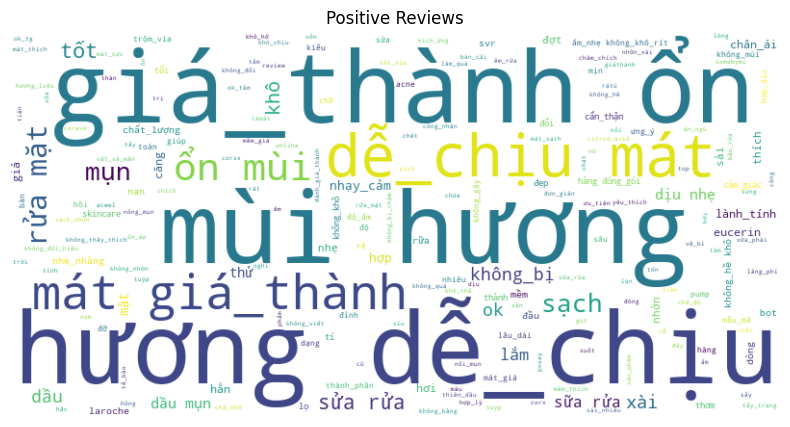

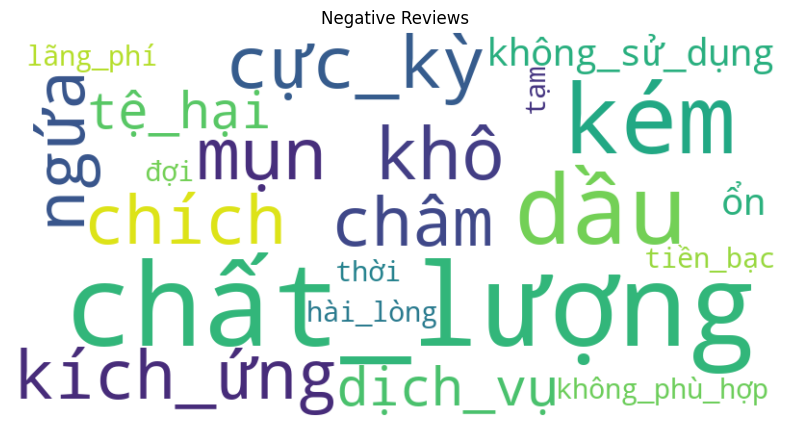

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Lọc dữ liệu
product_id = 204100019
product_data = df[df["ma_san_pham"] == product_id]
product_data
# Tính số lượng
positive_reviews = product_data[product_data["sentiment"] == "positive"]
negative_reviews = product_data[product_data["sentiment"] == "negative"]

print(f"Số nhận xét tích cực: {len(positive_reviews)}")
print(f"Số nhận xét tiêu cực: {len(negative_reviews)}")

# WordCloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

generate_wordcloud(positive_reviews["noi_dung_binh_luan_sau_xu_ly"], "Positive Reviews")
generate_wordcloud(negative_reviews["noi_dung_binh_luan_sau_xu_ly"], "Negative Reviews")